## Todo:
- Experiment with normalization while creating triplets
- Do you need dropout in the regressor network?
- Simultaneous feature learning?
- See when are results bad/equal/better? See which classes they correspond to.. 

In [1]:
%matplotlib inline
import cPickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from collections import defaultdict
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Conv2D
from keras.models import load_model
from keras.layers.pooling import MaxPooling2D
from keras import backend as K
import random
import pegasos
import time
from keras.layers import Input, BatchNormalization
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU

class SVM_Triplet:
    def __init__(self, X1, X2, Y, base_classes, pos_class, new_class):
        self.X1 = X1
        self.X2 = X2
        self.Y = Y
        self.base_classes = base_classes
        self.pos_class = pos_class
        self.new_class = new_class
        
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

# x = unpickle('/Users/admin/Downloads/cifar-100-python/train')

Using TensorFlow backend.


In [ ]:
'''
Returns a (32, 32, 3) image for a given array of 3072 pixels
'''
def reshape_img(pixels):
    r_channel = pixels[0:1024].reshape((32,32))
    g_channel = pixels[1024:2048].reshape((32,32))
    b_channel = pixels[1024:2048].reshape((32,32))
    return np.dstack((r_channel, g_channel, b_channel)) 


'''
Returns a custom dataset specific for incremental learning. 
The CIFAR dataset is broken down into 4 sub-datasets which would be used for incremental learning.
    - training : 40 classes which would be used for training our img classification network.
    - base : 20 classes which are considered as 'base'.
    - simulation : 20 classes. The new class would be picked from this category
    - test : 20 classes which would be used for testing our transformation network.
    
All the sub-datasets are mutually exclusive. 
'''
def create_custom_dataset(cifar):
    dataset = {'training': defaultdict(list), 'base':defaultdict(list) , 'simulation':defaultdict(list), 'test':defaultdict(list)}
    for ind in range(len(cifar['data'])):
        j = cifar['fine_labels'][ind]
        if j < 40:
            dataset['training'][j].append(reshape_img(cifar['data'][ind]))
        elif j >= 40 and j < 60:
            dataset['base'][j].append(reshape_img(cifar['data'][ind]))
        elif j >= 60 and j < 80:
            dataset['simulation'][j].append(reshape_img(cifar['data'][ind]))
        else:
            dataset['test'][j].append(reshape_img(cifar['data'][ind]))
    return dataset

In [ ]:
# custom_dataset = create_custom_dataset(x)
custom_dataset = unpickle('custom_dataset')

## Training our classifier network

We will now use the 40 classes labeled as 'training' from our custom dataset to train the classifier network. We will employ a simple network since the input images are only of size (32, 32, 3). 

- Conv (3x3x64) -> MaxPool -> ReLU
- Conv (3x3x128) -> MaxPool -> ReLU
- Conv (3x3x256) -> MaxPool -> ReLU -> dropout(0.9)
- FC(256)
- softmax(40)

In [ ]:
model = Sequential()

model.add(Conv2D(32, 3, activation='relu', input_shape=(32,32,3)))
model.add(Conv2D(32, 3, activation='relu', name='conv1_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Conv2D(64, 3, activation='relu', name='conv2_1'))
model.add(Conv2D(64, 3, activation='relu', name='conv2_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Flatten(name='flatten'))
model.add(Dense(1024, activation='relu', name='dense_1'))
model.add(Dropout(0.1))
model.add(Dense(1024, activation='relu', name='dense_2'))
model.add(Dropout(0.1))
model.add(Dense(40, name='dense_3'))
model.add(Activation('softmax', name='softmax'))

optimizer = keras.optimizers.SGD(lr=0.001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Prepare data for training
X, Y = [], []
for label in custom_dataset['training'].keys():
    for item in custom_dataset['training'][label]:
        X.append(item)
        Y.append(label)

model.fit(np.array(X), Y, epochs=100, batch_size=32, shuffle=True)
model.save('classifier_40_100.h5')

In [ ]:
# I had some issues with using the dropout layer during prediction. Some keras bug. 
# So had to rewrite the model without dropout
pmodel = Sequential()

pmodel.add(Conv2D(32, 3, activation='relu', input_shape=(32,32,3)))
pmodel.add(Conv2D(32, 3, activation='relu', name='conv1_2'))
pmodel.add(MaxPooling2D((2, 2), strides=(2, 2)))

pmodel.add(Conv2D(64, 3, activation='relu', name='conv2_1'))
pmodel.add(Conv2D(64, 3, activation='relu', name='conv2_2'))
pmodel.add(MaxPooling2D((2, 2), strides=(2, 2)))

pmodel.add(Flatten(name='flatten'))
pmodel.add(Dense(1024, activation='relu', name='dense_1'))
pmodel.add(Dense(1024, activation='relu', name='dense_2'))
pmodel.add(Dense(40, name='dense_3'))
pmodel.add(Activation('softmax', name='softmax'))

pmodel.load_weights('classifier_40_100.h5')
get_feature_vector = K.function([pmodel.layers[0].input],
                                  [pmodel.layers[8].output])

In [ ]:
feature_vectors = {'base': {} , 'simulation': {}, 'test': {}}

for dataset in custom_dataset.keys():
    if dataset != 'training':
        print dataset + ' .....'
        for label in custom_dataset[dataset].keys():
            inp = np.array(custom_dataset[dataset][label])
            feature_vectors[dataset][label] = get_feature_vector([inp])[0]
cPickle.dump(feature_vectors, open('feature_vectors', "wb" ))

In [17]:
def prepare_features(pos_class, neg_classes, feature_vectors, is_train=True, equal_features=False):
    
    # First 400 images will be used for training. Other 100 for testing
    TRAIN_SPLIT = 400
    
    pos_features = feature_vectors[pos_class]    # 500 x 1024 
    neg_features = []
    for neg_class in neg_classes:
        neg_features.extend(feature_vectors[neg_class])
    
    if equal_features:
        neg_features = np.random.permutation(neg_features)[:pos_features.shape[0]]
    
    if is_train:
        return pos_features[:TRAIN_SPLIT], np.array(neg_features[:TRAIN_SPLIT])
    else:
        return pos_features[TRAIN_SPLIT:], np.array(neg_features[TRAIN_SPLIT:])

# Modify feature_vectors structure
feature_vectors = unpickle('feature_vectors')
x = {}
for d in feature_vectors.keys():
    for label in feature_vectors[d].keys():
        x[label] = feature_vectors[d][label]
feature_vectors = x  

In [3]:
# Simulate triplet generation
triplets = unpickle('triplets.pkl')
# triplets = []
triplet_count = len(triplets)
print triplet_count

def compute_accuracy(weight_vector, pos_features, neg_features):
    classifier = pegasos.PegasosSVMClassifier()
    classifier.fit(np.zeros((2, 1024)), np.asarray([1, 0]))
    classifier.weight_vector.weights = weight_vector

    # Concat data and pass to SVM
    result = classifier.predict(np.vstack((pos_features, neg_features)))
    ground_truth = np.concatenate((np.ones(len(pos_features)), np.zeros(len(neg_features))))
    return np.average(np.equal(ground_truth, result))

def get_svm_weights(x_train, y_train):
    svm = pegasos.PegasosSVMClassifier()
    svm.fit(x_train, y_train)
    weight_vector = svm.weight_vector.weights
    return weight_vector


def get_x_y(pos_features, neg_features):
    x = np.vstack((pos_features, neg_features))
    y = np.hstack((np.ones( len(pos_features)),
                   np.zeros(len(neg_features))))
    return x, y

def compute_X1(pos_class, base_classes, feature_vectors):
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
    pos_features, neg_features = prepare_features(pos_class, neg_classes, feature_vectors)
    x_train, y_train = get_x_y(pos_features, neg_features)
    weight_vector = get_svm_weights(x_train, y_train)
    return weight_vector

def compute_X2(pos_class, base_classes, feature_vectors):
    pos_features, neg_features = prepare_features(pos_class, base_classes, feature_vectors)
    x_train, y_train = get_x_y(pos_features, neg_features)
    weight_vector = get_svm_weights(x_train, y_train)
    return weight_vector
    
def compute_Y(pos_class, new_class, base_classes, feature_vectors):
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
    neg_classes = np.append(neg_classes, new_class)
    pos_features, neg_features = prepare_features(pos_class, neg_classes, feature_vectors)
    x_train, y_train = get_x_y(pos_features, neg_features)
    weight_vector = get_svm_weights(x_train, y_train)
    return weight_vector
 
# # Generation of SVM triplets
while triplet_count < 100000:
    t_start = time.time()
    base_classes = np.random.permutation(range(40,60))[:10]
    
    X1s = {}
    for pos_class in base_classes:
        X1s[pos_class] = compute_X1(pos_class, base_classes, feature_vectors)
    
    X2s = {}
    for new_class in range(60,80):
        X2s[new_class] = compute_X2(new_class, base_classes, feature_vectors)
        
#     print 'Precomputation of X1 and X2 .. ', time.time() - t_start
    
    # The following code generates 200 triplets - 20C10 x 20C1
    for pos_class in base_classes:
        X1 = X1s[pos_class]
        for new_class in range(60, 80):
            X2 = X2s[new_class]
            Y = compute_Y(pos_class, new_class, base_classes, feature_vectors)
            triplets.append(SVM_Triplet(X1, X2, Y, base_classes, pos_class, new_class))
            triplet_count += 1
    
    # Snapshot after every 200 triplets
    with open('triplets.pkl', 'wb') as f:
        print 'Dumping start...'
        cPickle.dump(triplets, f)
        
    print triplet_count, time.time() - t_start
    

100000


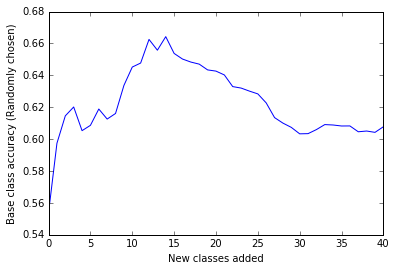

In [21]:
# Create a baseline
# SVM weights are not updated and new classes are added one by one
base_classes = np.random.permutation(range(40,60))[:10]
pos_class = random.choice(base_classes)
neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
X1 = compute_X1(pos_class, base_classes, feature_vectors)

pos_features_test, neg_features_test = prepare_features(pos_class, neg_classes, feature_vectors, is_train=False, equal_features=False)
acc = [compute_accuracy(X1, pos_features_test, neg_features_test)]

# neg_classes = []
for new_class in range(60, 100):
    neg_classes = np.append(neg_classes, new_class)
    pos_features_test, neg_features_test = prepare_features(pos_class, neg_classes, feature_vectors, is_train=False, equal_features=False)
    acc.append(compute_accuracy(X1, pos_features_test, neg_features_test))
    
plt.plot(range(0, 41), acc)
plt.ylabel('Base class accuracy (Randomly chosen)')
plt.xlabel('New classes added')
plt.show()

## Training the regressor network

In [9]:
triplets = unpickle('triplets.pkl')

In [12]:
inp = Input(shape=(2048,))
x = Dense(2048, name='dense_1')(inp)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1, name='lrelu_1')(x)
x = Dense(2048, name='dense_2')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1, name='lrelu_2')(x)
x = Dense(1024, name='dense_3')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1, name='lrelu_3')(x)
x = Dense(1024, name='dense_4')(x)

model = Model(inputs=inp, outputs=x)

optimizer = keras.optimizers.RMSprop(lr=0.001)

model.compile(loss='cosine_proximity', optimizer=optimizer, metrics=['accuracy'])

# Prepare data for training
X_train, Y_train = [], []
for triplet in triplets:
    ### NORMALIZE X1, X2 and Y here!!!
#     X1 = triplet.X1 / np.linalg.norm(triplet.X1, axis=0, keepdims=True)
#     X2 = triplet.X2 / np.linalg.norm(triplet.X2, axis=0, keepdims=True)
#     Y  = triplet.Y  / np.linalg.norm(triplet.Y,  axis=0, keepdims=True)
    
    X_train.append(np.hstack((triplet.X1, triplet.X2)))
    Y_train.append(triplet.Y-triplet.X1)


model.fit(np.array(X_train), np.array(Y_train), epochs=50, batch_size=32, shuffle=True, verbose=1)
time.sleep(0.1)
model.save('e100_rms_cosine_100k.h5')



Epoch 1/50
100000/100000 [==============================] - 680s - loss: -1.2678e-04 - acc: 0.0369   
Epoch 2/50
100000/100000 [==============================] - 790s - loss: -1.4937e-04 - acc: 0.0497   
Epoch 3/50
100000/100000 [==============================] - 1017s - loss: -1.5720e-04 - acc: 0.0552  
Epoch 4/50
100000/100000 [==============================] - 684s - loss: -1.6307e-04 - acc: 0.0570   
Epoch 5/50
100000/100000 [==============================] - 844s - loss: -1.6764e-04 - acc: 0.0613   
Epoch 6/50
100000/100000 [==============================] - 707s - loss: -1.7119e-04 - acc: 0.0643   
Epoch 7/50
100000/100000 [==============================] - 633s - loss: -1.7519e-04 - acc: 0.0689   
Epoch 8/50
100000/100000 [==============================] - 776s - loss: -1.7910e-04 - acc: 0.0738   
Epoch 9/50
100000/100000 [==============================] - 1141s - loss: -1.8050e-04 - acc: 0.0746  
Epoch 10/50
100000/100000 [==============================] - 1094s - loss: -1.8398

80 0.59 0.595
81 0.635 0.675
82 0.635 0.68
83 0.645 0.765
84 0.585 0.275
85 0.625 0.625
86 0.515 0.575
87 0.61 0.62
88 0.585 0.67
89 0.565 0.65
90 0.72 0.655
91 0.65 0.61
92 0.715 0.805
93 0.63 0.615
94 0.545 0.63
95 0.645 0.715
96 0.69 0.59
97 0.525 0.575
98 0.545 0.615
99 0.66 0.635


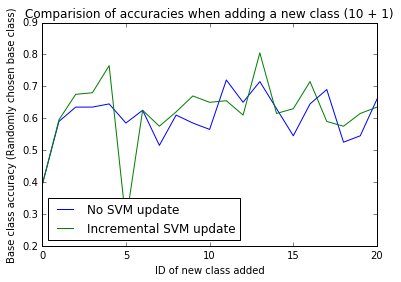

In [27]:
# Compare our model with the baseline
model = load_model('e100_rms_cosine_100k.h5')
acc, our_acc, true_acc = [], [], []
base_classes = np.random.permutation(range(40,60))[:10]
pos_class = random.choice(base_classes)
X1 = compute_X1(pos_class, base_classes, feature_vectors)

neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
pos_features_test, neg_features_test = prepare_features(pos_class, neg_classes, feature_vectors, False) 
acc.append(compute_accuracy(X1, pos_features_test, neg_features_test))
our_acc.append(acc[0])

our_X1 = X1
# neg_classes = []
for new_class in range(80, 100):
    neg_classes = [new_class]
#     neg_classes.append(new_class)
    pos_features_test, neg_features_test = prepare_features(pos_class, neg_classes, feature_vectors, is_train=False, equal_features=True)
    acc1 = compute_accuracy(X1, pos_features_test, neg_features_test)
    acc.append(acc1)
        
    # Test out our incremental hypothesis
#     our_X1 = X1 / np.linalg.norm(X1, axis=0, keepdims=True)
    X2 = compute_X2(new_class, base_classes, feature_vectors)
#     X2 = X2 / np.linalg.norm(X2, axis=0, keepdims=True)
    X = np.hstack((our_X1, X2))
    X = np.reshape(X, (1, 2048))
    Y_hat = model.predict(X)
    Y = our_X1 + Y_hat.reshape((1024))
#     our_X1 = Y.reshape((1024))
#     Y = Y * np.linalg.norm(X1, axis=0, keepdims=True)
    acc2 = compute_accuracy(Y, pos_features_test, neg_features_test)
    our_acc.append(acc2)
    
    
    print new_class, acc1, acc2
    
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(0, len(acc)), acc, 'b', label='No SVM update')
ax.plot(range(0, len(our_acc)), our_acc, 'g', label='Incremental SVM update')
plt.ylabel('Base class accuracy (Randomly chosen base class)')
plt.xlabel('ID of new class added')
ax.legend(loc=3)
plt.title('Comparision of accuracies when adding a new class (10 + 1)')
plt.show()